# Experiment

## Prerequisites

Extract the data to `./metrics`

## Preparations

Import necessary libraries

Idées de mesures:

- distribution des fonctions
- politique basique edge first ou quoi
- temps de deploiement vs nombre de noeuds dans le Fog
- temps de deploiement vs nombre de fonctions
- la mémoire et le cpu au niveau du noeud fog

In [182]:
#install.packages('IRkernel') # Requires the tk package
#IRkernel::installspec()  # to register the kernel in the current R installation

In [183]:
# To call python from R
library(reticulate)
library(tidyverse)
library(igraph)
library(r2r)
library(formattable)

Load the the Python `integration.py` script to use its variable in R

In [184]:
use_virtualenv('.venv/', required = TRUE)
import_from_path("monitoring", path = ".")

# Always throws an error because it is a CLI tool; it is not made to be loaded in R
try(source_python('integration.py')) 

Module(monitoring)

Error in py_run_file_impl(file, local, convert) : SystemExit: 0



Load the graph network as an adjancency matrix

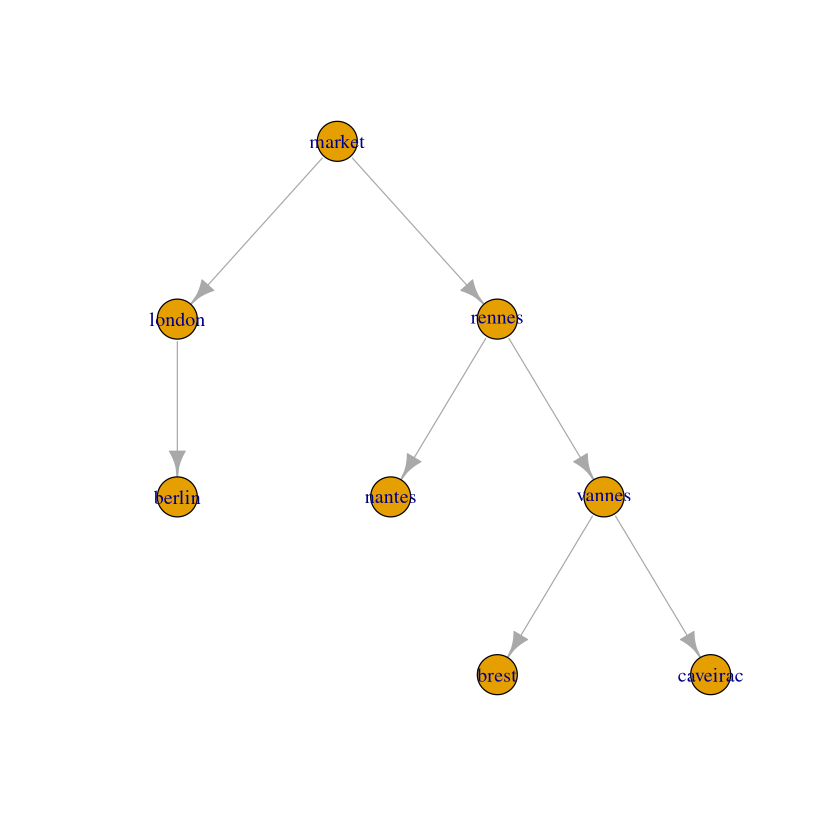

In [185]:
raw <- py$ADJACENCY

adjancy_transform <- function(x) {
  ret = matrix(0, nrow = length(x), ncol = length(x))
  rownames(ret) <- c(sort(names(x)))
  colnames(ret) <- c(sort(names(x)))
  for (ii in seq_along(x)) {
    for (jj in seq_along(x[[ii]])) {
      ret[names(x)[[ii]], x[[ii]][[jj]][[1]]] <- strtoi(x[[ii]][[jj]][[2]])
    }

  }
  return(ret)
}

graph_matrix <- adjancy_transform(raw)
net <- graph_from_adjacency_matrix(as.matrix(graph_matrix), weighted = TRUE)
plot(net, layout=layout_as_tree)

# ceb <- cluster_edge_betweenness(g)
#
# dendPlot(ceb, mode="hclust")
# plot(ceb, g)


## Data preprocessing

In [186]:
names_raw <- read.csv2(file = 'metrics/names.csv', header = TRUE, sep = '\t')
names <- hashmap()
names[names_raw$instance] <- names_raw$name

missing <- data.frame(instance = names_raw$name, n = 0)

Load the names of the node and their correspondance in their IP on the virtual network

In [187]:
prepare <- function(x) {
  return(
    x %>%
      mutate(instance = names[instance]) %>%
      mutate(instance = as.character(instance)) %>%
      mutate(timestamp = as.numeric(as.character(timestamp))) %>%
      mutate(timestamp = as.POSIXct(timestamp, origin = "1970-01-01")) %>%
      mutate(value = as.numeric(as.character(value))) %>%
      merge(missing, all = TRUE) %>%
      arrange(instance)
  )
}

## Data processing

Check what nodes we have values for (usually the ones who have submitted bids and etc.):
- Green is ok
- Red is a node that was not present in the data

In [188]:
mem <- read.csv2(file = 'metrics/fog_node_memory_available.csv', header = TRUE, sep = '\t') %>%
    prepare %>%
    distinct(instance, value, .keep_all = TRUE) %>%
    select(c(instance, value)) %>%
    mutate(dyn = formattable::percent(value / max(value, na.rm=TRUE))) %>%
    mutate(value = as.numeric(as.character(value)))

cpu_raw <- read.csv2(file = 'metrics/fog_node_cpu_used.csv', header = TRUE, sep = '\t') %>%
    prepare %>%
    select(c(instance, value)) %>%
    distinct(instance, value, .keep_all = TRUE) %>%
    group_by(instance) %>%
    mutate(value = as.numeric(as.character(value)))


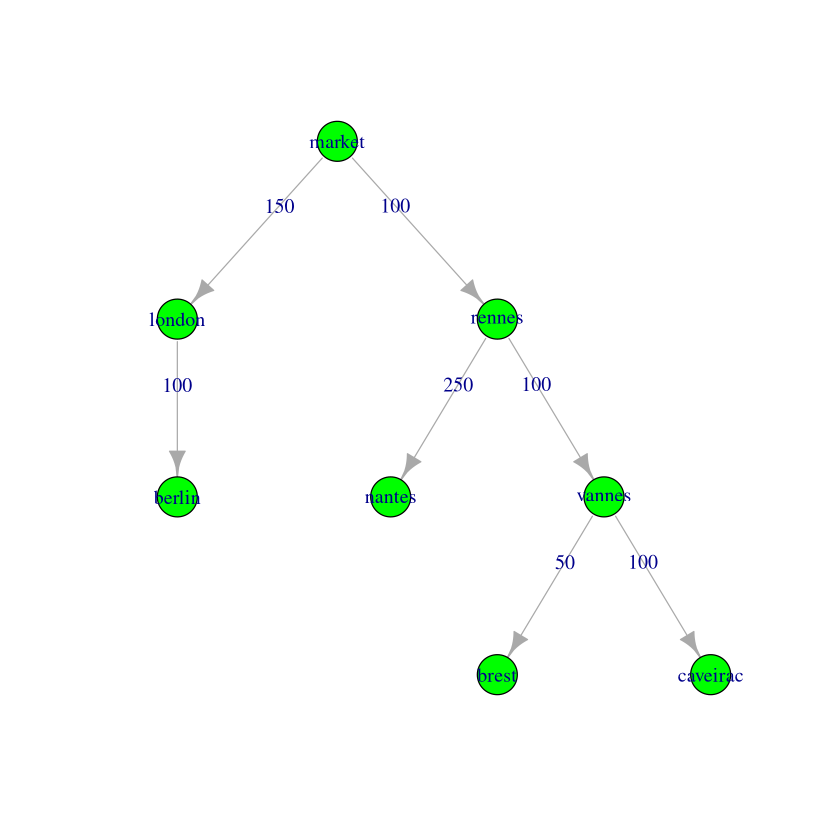

In [189]:
PercentageColourConnected <- function(x) { colorRampPalette(c('red', 'green'))(2)[ifelse(is.na(x), 1, 2)] }
net_connected <- graph_from_adjacency_matrix(as.matrix(graph_matrix), weighted = TRUE)
V(net_connected)$color <- PercentageColourConnected(mem$value)
plot(net_connected, layout = layout_as_tree, edge.label = E(net_connected)$weight)

Describe what nodes we have:
- size is the number of CPUs
- color is the RAM (purple is the max in the network)

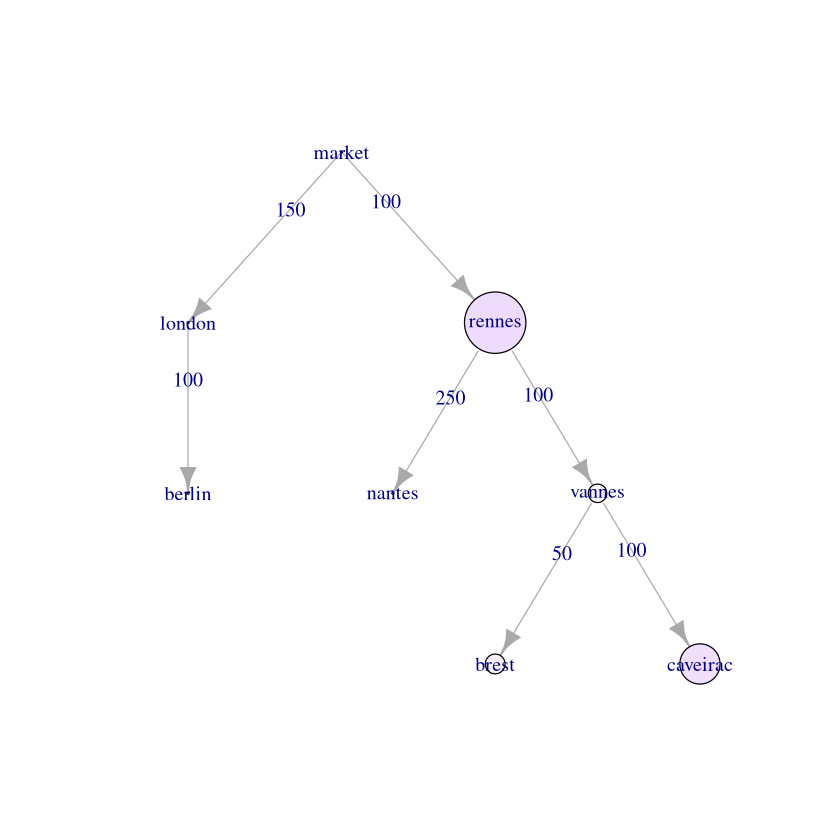

In [190]:
PercentageColour <- function(x){colorRampPalette(c('white','purple'))(101)[round(ifelse(is.na(x), 0, x)*100)+1]}
net_prez <- graph_from_adjacency_matrix(as.matrix(graph_matrix), weighted = TRUE)
V(net_prez)$size <- ifelse(is.na(cpu$value), 0, cpu$value * 4)
V(net_prez)$color <- PercentageColour(mem$dyn)
plot(net_prez, layout = layout_as_tree, edge.label = E(net_prez)$weight)

instance,n
<chr>,<int>
caveirac,3
rennes,3


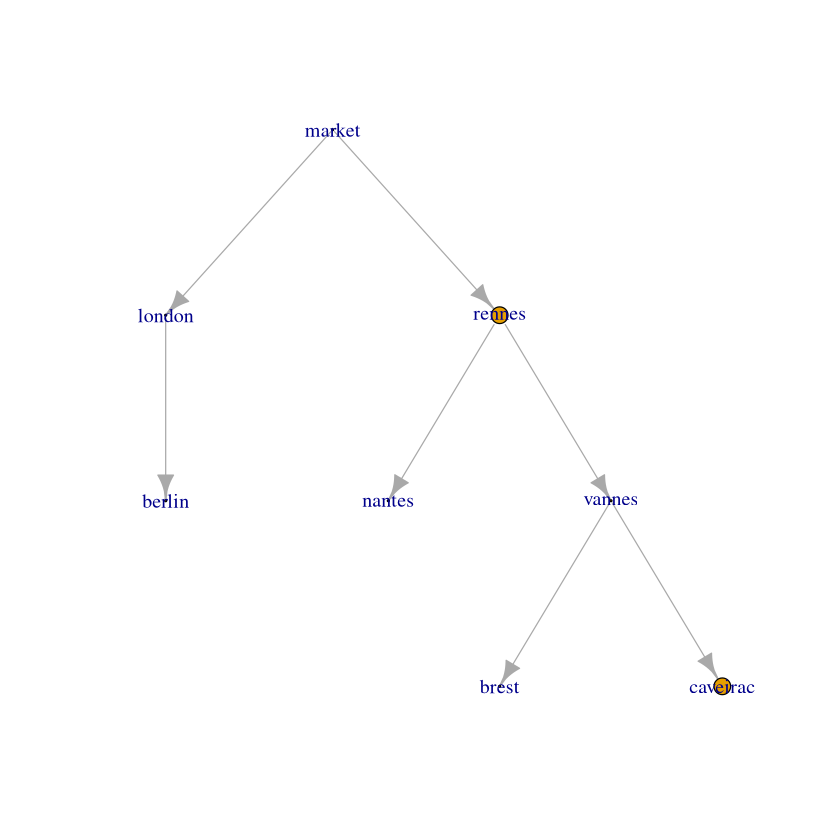

In [191]:
bids_won_raw <- bids_raw %>%
  select(c(instance, function_name, value))

bids_won_all_zero <- data.frame(instance = names_raw$name, n = 0)
bids_won <- bids_won_raw %>%
  group_by(function_name) %>%
  slice(which.min(value)) %>%
  group_by(instance) %>%
  summarise(n = n())

bids_won

# Add missing participants and put them at 0
bids_won <- bids_won %>%
  merge(bids_won_all_zero, all = TRUE) %>%
  group_by(instance) %>%
  summarise(across(everything(), sum)) %>%
  arrange

net_won <- graph_from_adjacency_matrix(as.matrix(graph_matrix), weighted = TRUE)
V(net_won)$size <- bids_won$n * 2
plot(net_won, layout = layout_as_tree)


Plot the free memory

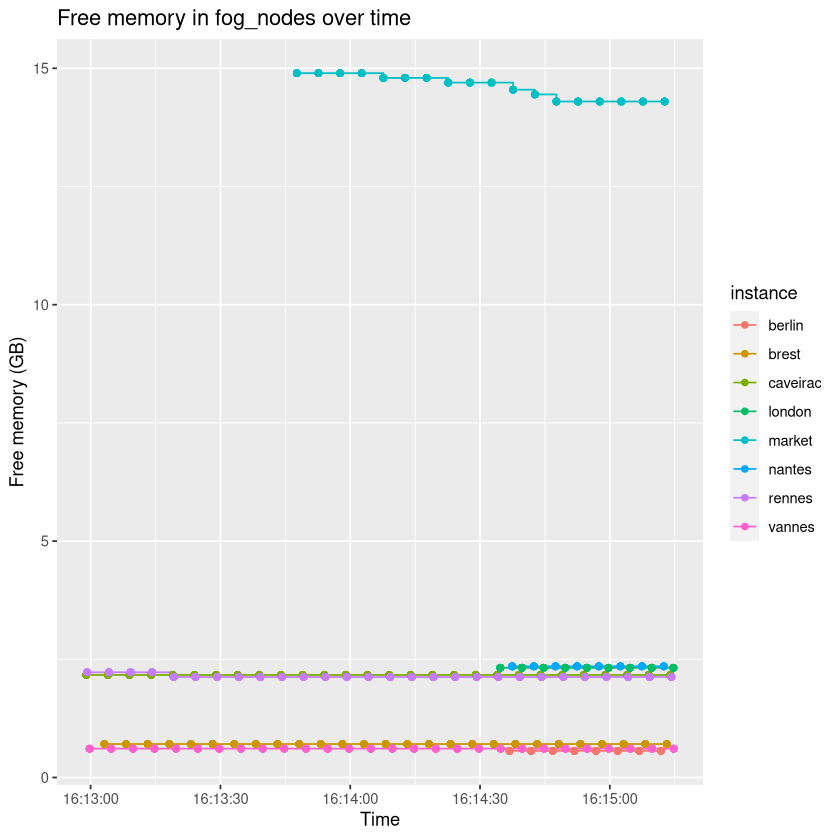

In [198]:
mem_used <- read.csv2(file = 'metrics/fog_node_memory_used.csv', header = TRUE, sep = '\t') %>% prepare
mem_avail <- read.csv2(file = 'metrics/fog_node_memory_available.csv', header = TRUE, sep = '\t') %>% prepare

mem_free <- mem_used %>%
        inner_join(mem_avail, by=c("instance", "timestamp")) %>%
        mutate(free = (value.y - value.x)/1e09) %>%
        select(instance, timestamp, free)

mem_free %>%
  ggplot(aes(x = timestamp, y = free, color = instance)) +
  geom_step() +
  geom_point() +
  labs(x="Time", y="Free memory (GB)", title="Free memory in fog_nodes over time")

Latency of the nodes from their rolling average

`summarise()` has grouped output by 'instance'. You can override using the
`.groups` argument.


instance,instance_to,mean_ms
<chr>,<chr>,<dbl>
berlin,london,201
brest,vannes,101
caveirac,vannes,201
london,berlin,201
london,market,301
market,london,301
market,rennes,201
nantes,rennes,501
rennes,market,201


`geom_smooth()` using method = 'loess' and formula 'y ~ x'



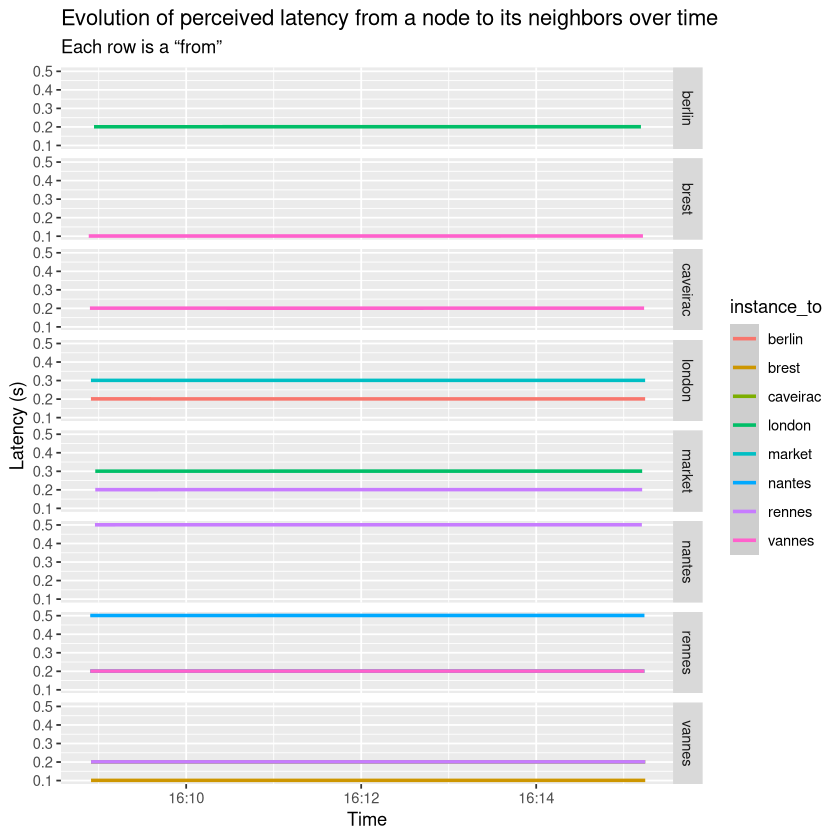

In [193]:
latency <- read.csv2(file = 'metrics/fog_node_neighbors_latency_rolling_avg.csv', header = TRUE, sep = '\t') %>%
  prepare %>%
  mutate(instance_to = as.character(names[instance_to]))

latency %>%
  group_by(instance, instance_to) %>%
  summarise(mean_ms = round(mean(value*1000), 0))

latency %>%
  ggplot(aes(x = timestamp, y = value, color = instance_to)) +
  geom_smooth() +
  labs(x="Time", y="Latency (s)", title="Evolution of perceived latency from a node to its neighbors over time", subtitle = "Each row is a “from”") +
  facet_grid(rows = vars(instance))

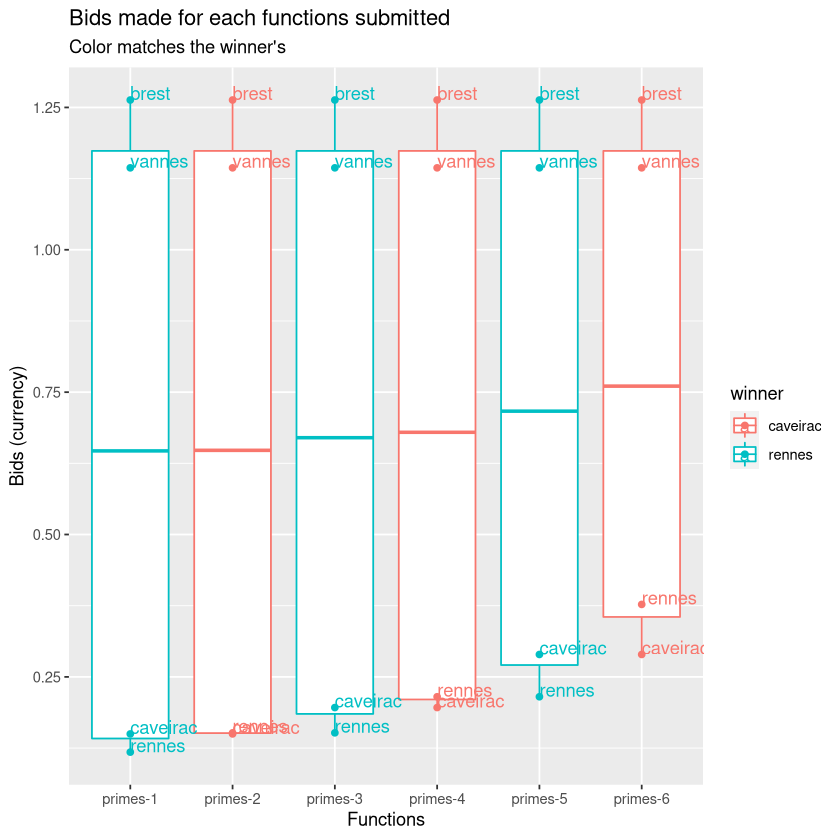

In [199]:
bids_won_function <- bids_won_raw %>%
  group_by(function_name) %>%
  slice(which.min(value)) %>%
  mutate(winner = instance)

bids_function <- bids_raw %>%
  select(c(instance, function_name, value)) %>%
  distinct() %>%
  inner_join(bids_won_function, by = c("function_name"))


bids_function %>%
  ggplot(aes(x = function_name, y = value.x, group = function_name, color = winner, label = instance.x)) +
  geom_boxplot() +
  geom_point() +
  geom_text(hjust = 0, vjust = 0) +
  labs(x="Functions", y="Bids (currency)", title="Bids made for each functions submitted", subtitle="Color matches the winner's")
